In [1]:
import datacube
from datacube.utils import masking
from odc.algo import binary_dilation

dc = datacube.Datacube()

import sys
sys.path.append("../Scripts")
from dea_dask import create_local_dask_cluster

create_local_dask_cluster(spare_mem='4Gb')

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


Client Scheduler: tcp://127.0.0.1:36739 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 7 Memory: 62.57 GB


In [275]:
import datacube
import datetime
from datacube.model import Range, Dataset
from datacube.utils.dates import normalise_dt
import collections
import pandas as pd

dc = datacube.Datacube()

#################
# Find datasets #
#################

y, x = -38.739248, 146.657652
# y, x = -43.445542, 147.052884
buffer = 0.1


# Set query
query = {
    'x': (x - buffer, x + buffer),
    'y': (y - buffer, y + buffer),
    'time': ('1988', '2020')
}

# Find datsets for all three geomedians
dss_ls5 = dc.find_datasets(product='ls5_nbart_geomedian_annual', **query)
dss_ls7 = dc.find_datasets(product='ls7_nbart_geomedian_annual', **query)
dss_ls8 = dc.find_datasets(product='ls8_nbart_geomedian_annual', **query)

##################
# Custom GroupBy #
##################


def _extract_time_from_ds(ds: Dataset) -> datetime.datetime:
    return normalise_dt(ds.center_time)


def sort_by_platform(ds):
    date = normalise_dt(ds.center_time)
    order = {'LANDSAT_5': 2, 'LANDSAT_7': 3, 'LANDSAT_8': 1}
    return f'{date:%Y}_{order[ds.metadata.platform]}_{ds.metadata.platform}'


GroupBy = collections.namedtuple(
    'GroupBy', ['dimension', 'group_by_func', 'units', 'sort_key'])
platform_grouper = GroupBy(dimension='time',
                           group_by_func=_extract_time_from_ds,
                           units='seconds since 1970-01-01 00:00:00',
                           sort_key=sort_by_platform)

#############
# Load data #
#############

ds = dc.load(datasets=dss_ls5 + dss_ls7 + dss_ls8,
             measurements=['swir1', 'green', 'blue', 'red'],
             resolution=(-30, 30),
#              dask_chunks={},
             group_by=platform_grouper,
             **query)

ds['time'] = pd.to_datetime(ds.time.str[0:4])
ds

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


<xarray.Dataset>
Dimensions:      (time: 33, x: 666, y: 796)
Coordinates:
  * time         (time) datetime64[ns] 1988-01-01 1989-01-01 ... 2020-01-01
  * y            (y) float64 -4.298e+06 -4.298e+06 ... -4.321e+06 -4.322e+06
  * x            (x) float64 1.274e+06 1.274e+06 ... 1.294e+06 1.294e+06
    spatial_ref  int32 3577
Data variables:
    swir1        (time, y, x) int16 2157 2185 2247 2144 2158 ... 132 130 130 123
    green        (time, y, x) int16 628 625 683 580 620 ... 342 343 337 329 327
    blue         (time, y, x) int16 311 305 307 267 261 ... 500 498 489 480 477
    red          (time, y, x) int16 507 508 509 428 437 ... 238 239 234 226 225
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [276]:
mndwi = ((ds.green - ds.swir1) / (ds.green + ds.swir1))


In [277]:
# Apply water index threshold
thresholded_ds = mndwi < 0
 
# Create a temporal mask by dilating water area, then finding pixels
# that have a neighbour in at least the previous or subsequent timestep.
# Effectively, this requires land to be located 
kernel=disk(5)
mndwi_dilated = xr.apply_ufunc(binary_dilation, thresholded_ds, kernel.reshape((1, ) + kernel.shape))
mndwi_rolling = mndwi_dilated.rolling(time=3, center=True, min_periods=1).sum()
temporal_mask = (mndwi_rolling > 1)

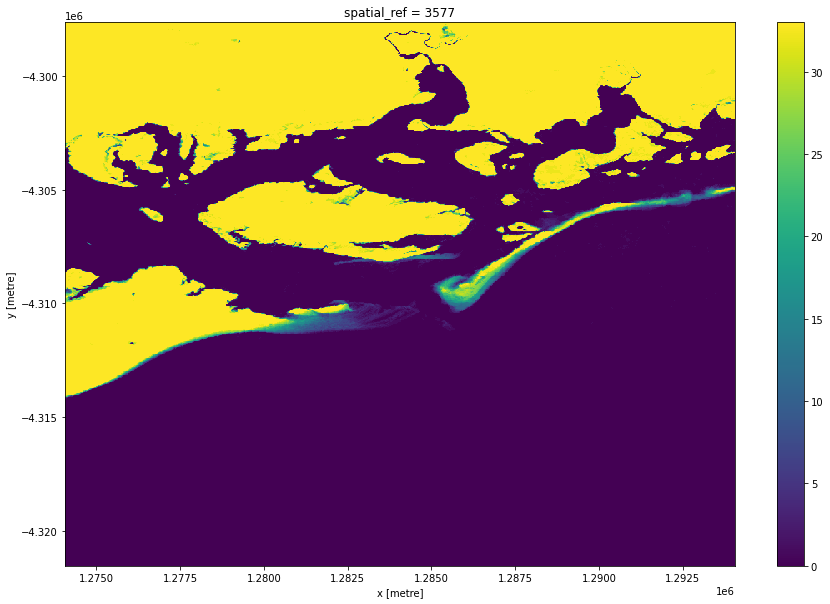

In [278]:
thresholded_ds.sum(dim='time').plot(size=10)

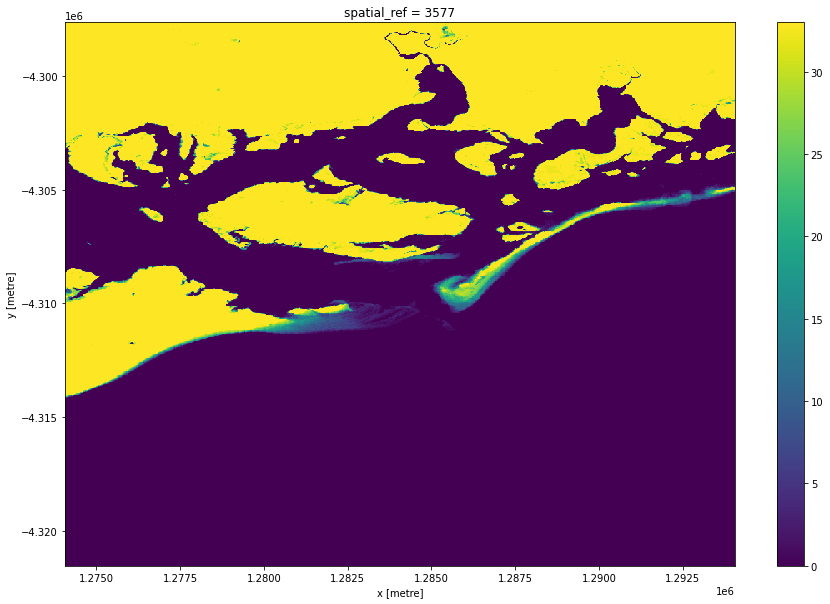

In [279]:
thresholded_ds.where(temporal_mask).sum(dim='time').plot(size=10)

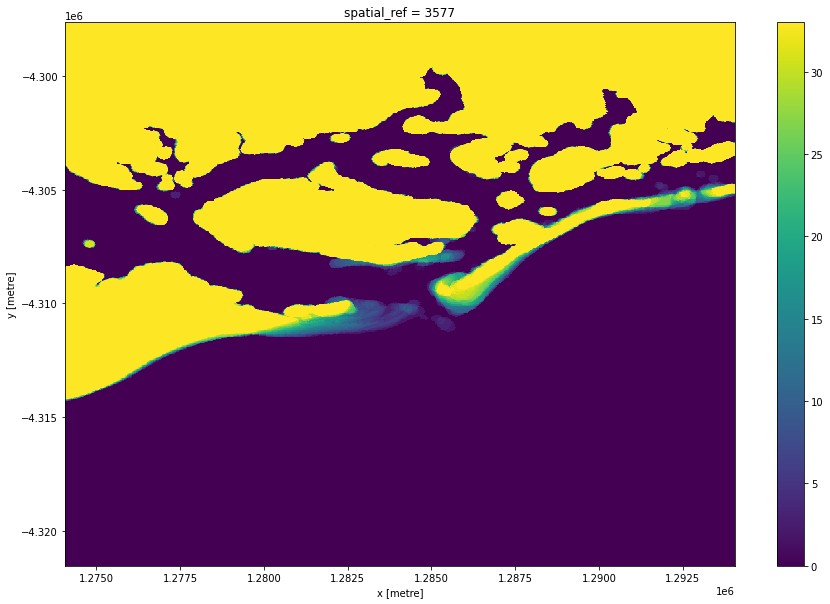

In [280]:
temporal_mask.sum(dim='time').plot(size=10)

In [ ]:
# from percentile import xr_quantile

In [ ]:
# import numpy as np
# out = xr_quantile(mndwi_binary.where(temporal_mask).to_dataset(name='mndwi'), [0.], np.NaN)

In [ ]:
# temporal_mask.plot(col='time', col_wrap=5)

In [62]:
# (mndwi_binary & temporal_mask).plot(col='time', col_wrap=3, size=7)    #.mean(dim='time') > 0.7).plot(size=20)

### Extracting ocean

In [301]:
import xarray as xr
from skimage.morphology import disk, square
from skimage.morphology import binary_dilation, binary_opening, binary_closing
from shapely.geometry import Point
import geopandas as gpd
from skimage.measure import label
import matplotlib.pyplot as plt

def mask_ocean(bool_array, tide_points_gdf, connectivity=1, dilation=0):
    """
    Identifies ocean by selecting the largest connected area of water
    pixels that contain tidal modelling points, then dilating this 
    region to ensure sub-pixel algorithm has pixels on either side of 
    the water index threshold.
    
    Parameters:
    -----------
    bool_array : xarray.DataArray
        An array containing True for water pixels, and False for non-
        water. This can be obtained by thresholding a water index
        array (e.g. MNDWI > 0).
    tide_points_gdf : geopandas.GeoDataFrame
        Spatial points located within the ocean. These points are used
        to ensure that all coastlines are directly connected to the 
        ocean.
    connectivity : integer, optional
        An integer passed to the 'connectivity' parameter of the
        `skimage.measure.label` function.
        
    Returns:
    --------
    ocean_mask : nd.array
        An array containing the a mask consisting of identified ocean 
        pixels.
    
    """
    
    # First, break boolean array into unique, discrete regions/blobs
    blobs_labels = xr.apply_ufunc(label, bool_array, None, 0, False, connectivity)
    
    # Get blob ID for each tidal modelling point
    x = xr.DataArray(tide_points_gdf.geometry.x, dims='z')
    y = xr.DataArray(tide_points_gdf.geometry.y, dims='z')   
    ocean_blobs = np.unique(blobs_labels.interp(x=x, y=y, method='nearest'))

    # Return only blobs that contained tide modelling point
    ocean_mask = blobs_labels.isin(ocean_blobs)
    
    # Dilate mask so that we include land pixels on the inland side
    # of each shoreline to ensure contour extraction accurately
    # seperates land and water spectra
    ocean_mask = xr.apply_ufunc(binary_dilation, ocean_mask, disk(dilation))

    return ocean_mask


In [302]:
# Identify pixels that are land in at least 10% of observations
all_time = (thresholded_ds & temporal_mask).mean(dim='time') >= 0.1

In [303]:
buffer_pixels = 33

# Clean with opening to remove small areas of stray noisy pixels
all_time_cleaned = all_time
all_time_cleaned = xr.apply_ufunc(binary_closing, all_time, disk(3))

# Identify ocean pixels that are directly connected to tide points
tide_points_gdf = gpd.GeoDataFrame(
    geometry=[Point(all_time.isel(x=-5, y=-5).x,
                    all_time.isel(x=-5, y=-5).y)],
    crs='EPSG:3577')
all_time_ocean = mask_ocean(all_time_cleaned, tide_points_gdf)

# Generate coastal buffer from ocean-land boundary
buffer_ocean = xr.apply_ufunc(binary_dilation, all_time_ocean,
                              disk(buffer_pixels))
buffer_land = xr.apply_ufunc(binary_dilation, ~all_time_ocean,
                             disk(buffer_pixels))
coastal_buffer = buffer_ocean & buffer_land

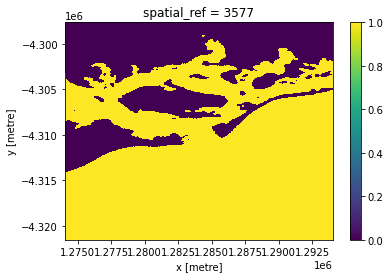

In [304]:
all_time_ocean.plot()

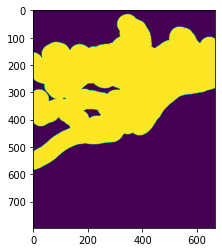

In [305]:
plt.imshow(coastal_buffer)

In [292]:
# Write GeoTIFF
from datacube.utils.cog import write_cog
write_cog(geo_im=coastal_buffer.astype(np.int16),
          fname='ocean.tif',
          overwrite=True)

PosixPath('ocean.tif')

In [214]:
# Write GeoTIFF
from datacube.utils.cog import write_cog
write_cog(geo_im=mndwi.where(temporal_mask & coastal_buffer).isel(time=0),
          fname='test.tif',
          overwrite=True)


PosixPath('test.tif')

In [194]:
from dea_spatialtools import subpixel_contours

contours_extract = mndwi.where(temporal_mask & coastal_buffer).compute()

subpixel_contours(contours_extract, z_values=0, crs=mndwi.geobox.crs, output_path='test.geojson', min_vertices=5)

,time,geometry
0,1988-01-01,"MULTILINESTRING ((1285395.000 -4298003.455, 12..."
1,1989-01-01,"MULTILINESTRING ((1285395.000 -4297998.864, 12..."
2,1990-01-01,"MULTILINESTRING ((1285455.000 -4297943.654, 12..."
3,1991-01-01,"MULTILINESTRING ((1284255.000 -4298243.142, 12..."
4,1992-01-01,"MULTILINESTRING ((1284405.000 -4298091.258, 12..."
5,1993-01-01,"MULTILINESTRING ((1284255.000 -4298240.762, 12..."
6,1994-01-01,"MULTILINESTRING ((1285395.000 -4298028.293, 12..."
7,1995-01-01,"MULTILINESTRING ((1285395.000 -4298081.694, 12..."
8,1996-01-01,"MULTILINESTRING ((1285395.000 -4298059.336, 12..."
9,1997-01-01,"MULTILINESTRING ((1284255.000 -4298242.803, 12..."
